# CS 4452 Assignment 1

## Problem 1: Image Detection

In [11]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt

##### 1a. Loading Image 1

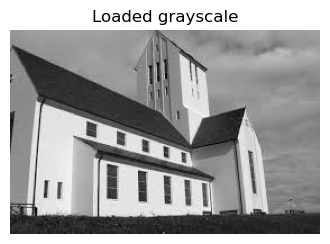

In [12]:
# Load image
image = plt.imread('image1.png')

if image.ndim == 2:
    grayscale = image
else:
    # RGB or RGBA -> drop alpha if present, then average channels
    grayscale = image[..., :3].mean(axis=2)

# normalize depending on dtype/range
grayscale = grayscale.astype(np.float32)
float_image = grayscale / (255.0 if grayscale.max() > 1.0 else 1.0)

plt.figure(figsize=(4,4))
plt.imshow(float_image, cmap="gray")
plt.axis("off")
plt.title("Loaded grayscale")
plt.show()

### 1b. Apply Filters & Plotting 

implementing 3×3 Sobel filters 𝑆𝑥and 𝑆𝑦to each smoothed image from (a). Plot the
resulting 𝐺𝑥and 𝐺𝑦images (and optionally the gradient magnitude).

In [13]:
def gaussian_kernel(size=5, sigma=1.0):
    """Create a size x size Gaussian kernel"""
    # Create a coordinate grid centered at 0
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    
    # Calculate Gaussian values
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    
    # Normalize so sum equals 1
    return kernel / np.sum(kernel)

# Create 5x5 Gaussian kernel
kernel = gaussian_kernel(5, sigma=1.0)
print(kernel)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


### 1c. Convolving Image 1 

using derivative-of-Gaussian filters ∂𝐺/ ∂𝑥 and ∂𝐺/ ∂𝑦, using
5×5 filters for σ = 1 and σ = 2. Plot the resulting 𝐺𝑥and 𝐺𝑦images for each σ

In [14]:
def convolve2d_manual(img, kernel, padding="reflect"):
    img = np.asarray(img, dtype=np.float32)
    kernel = np.asarray(kernel, dtype=np.float32)

    kh, kw = kernel.shape
    assert kh % 2 == 1 and kw % 2 == 1, "Kernel must have odd dimensions (e.g., 5x5)"
    pad_h, pad_w = kh // 2, kw // 2

    # Flip kernel for convolution
    k = np.flipud(np.fliplr(kernel))

    pad_mode = {"reflect": "reflect", "edge": "edge", "constant": "constant"}[padding]
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode=pad_mode)

    H, W = img.shape
    out = np.zeros((H, W), dtype=np.float32)

    for i in range(H):
        for j in range(W):
            region = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(region * k)

    return out

#### 1d. Comparision 

the results of (b) and (c). Describing what is observed and why.

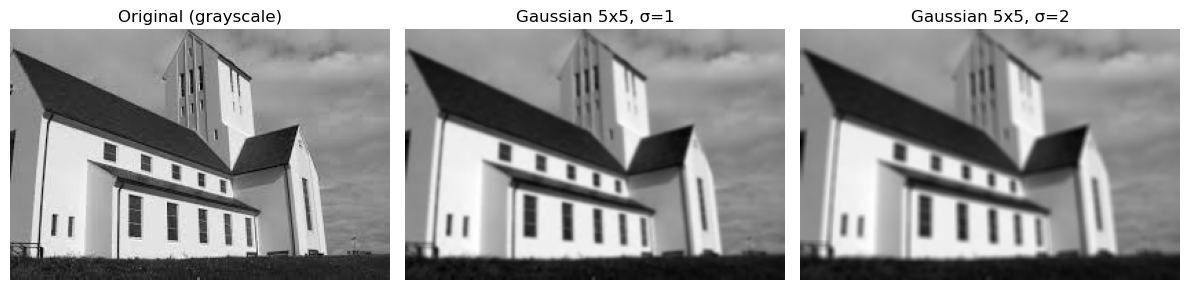

In [15]:
# Gaussian smoothing with sigma=1 and sigma=2
k1 = gaussian_kernel(5, sigma=1.0)
k2 = gaussian_kernel(5, sigma=2.0)

smooth_sigma1 = convolve2d_manual(float_image, k1, padding="reflect")
smooth_sigma2 = convolve2d_manual(float_image, k2, padding="reflect")

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original (grayscale)")
plt.imshow(float_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Gaussian 5x5, σ=1")
plt.imshow(smooth_sigma1, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Gaussian 5x5, σ=2")
plt.imshow(smooth_sigma2, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

## Problem 2: Corner Detection

#### 1. Harris Corner Detector 

Implementing step-by-step and applying it to Image 1 and provide:

 - the corner response map 𝑅, and

 - the output after non-maximum suppression (final detected corners, ideally
overlaid on the image). 

#### 2b. Spatial derivative calculation


In [ ]:
# 2) Spatial derivatives (Sobel)
Sx = np.array([[-1, 0,  1],
               [-2, 0,  2],
               [-1, 0,  1]], dtype=np.float32)

Sy = np.array([[-1, -2, -1],
               [ 0,  0,  0],
               [ 1,  2,  1]], dtype=np.float32)

# using grayscale float_image from problem 1
Ix = convolve2d_manual(float_image, Sx, padding="reflect")
Iy = convolve2d_manual(float_image, Sy, padding="reflect")

#### 2c. Structure tensor setup (M)

In [ ]:
# Structure tensor terms (with Gaussian smoothing)
k = 0.04
sigma = 1.0
win = 5
G = gaussian_kernel(win, sigma=sigma)

Ixx = Ix * Ix
Iyy = Iy * Iy
Ixy = Ix * Iy

Sxx = convolve2d_manual(Ixx, G, padding="reflect")
Syy = convolve2d_manual(Iyy, G, padding="reflect")
Sxy = convolve2d_manual(Ixy, G, padding="reflect")

#### 2d. Corner response calculation

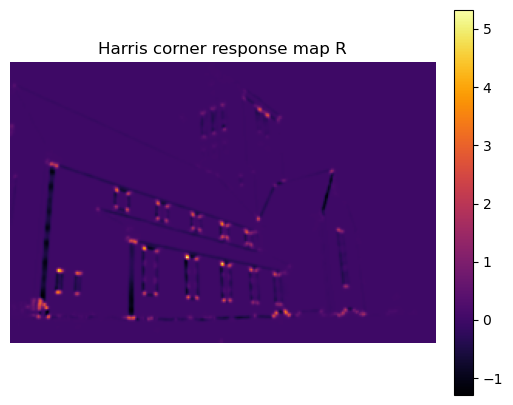

In [ ]:
# Corner response map R
detM = Sxx * Syy - Sxy * Sxy
traceM = Sxx + Syy
R = detM - k * (traceM ** 2)

# Plot corner response map R
plt.figure(figsize=(6, 5))
plt.title("Harris corner response map R")
plt.imshow(R, cmap="inferno")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")
plt.show()

#### 2e. Non-maximum suppression

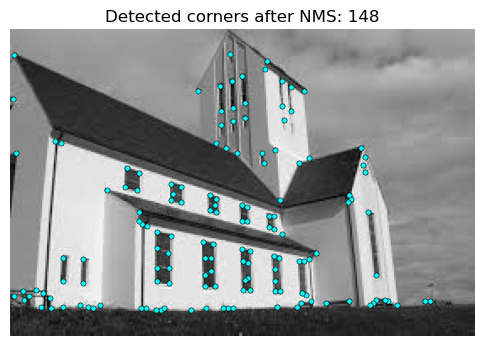

In [ ]:
# Non-maximum suppression (simple local-max + threshold)
def nms(R, threshold_rel=0.01, nms_size=3, max_points=300):
    R = np.asarray(R, dtype=np.float32)
    Rmax = float(R.max())
    if Rmax <= 0:
        return []

    thresh = threshold_rel * Rmax
    r = nms_size // 2
    H, W = R.shape

    pts = []
    for i in range(r, H - r):
        for j in range(r, W - r):
            v = R[i, j]
            if v < thresh:
                continue
            window = R[i-r:i+r+1, j-r:j+r+1]
            if v == window.max():
                pts.append((i, j, v))

    pts.sort(key=lambda t: t[2], reverse=True)
    pts = pts[:max_points]
    return [(i, j) for (i, j, _) in pts]

corners = nms(R, threshold_rel=0.01, nms_size=3, max_points=300)

# Overlay corners on image
plt.figure(figsize=(6, 6))
plt.title(f"Detected corners after NMS: {len(corners)}")
plt.imshow(float_image, cmap="gray")
if corners:
    ys = [p[0] for p in corners]
    xs = [p[1] for p in corners]
    plt.scatter(xs, ys, s=14, c="cyan", edgecolors="black", linewidths=0.4)
plt.axis("off")
plt.show()